In [124]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from statistics import mean, median
from math import sqrt
from scipy.stats import mannwhitneyu
import matplotlib.style as mpl_style
import numpy as np
import pandas as pd
from typing import Tuple, List, Dict, Set, Iterable
import matplotlib.style as mpl_style
import os
import json
%matplotlib inline

In [125]:
# path to csv results
AIRFOIL_PATH_1 = "./airfoil_1gen_50hn/results.csv"
AIRFOIL_PATH_2 = "./airfoil_1gen_100hn/results.csv" # change later!
AIRFOIL_PATH_3 = "./airfoil_1gen_200hn/results.csv" # change path later!
IMG_PATH="/Users/rmn/masterThesis/master_thesis/img/airfoil_firstGen"

In [126]:
def df_from_path(path: str) -> pd.DataFrame:
    return pd.read_csv(
        filepath_or_buffer=path,
        sep="?",
    )

In [127]:
AIRFOIL_RESULTS_1 = df_from_path(AIRFOIL_PATH_1)
AIRFOIL_RESULTS_2 = df_from_path(AIRFOIL_PATH_2)
AIRFOIL_RESULTS_3 = df_from_path(AIRFOIL_PATH_3)

In [128]:
def split_df(df: pd.DataFrame, dir1: str, dir2: str) -> Tuple[pd.DataFrame, pd.DataFrame]:
    return df.query("directory == @dir1").copy(), df.query("directory == @dir2").copy()

In [129]:
pt_results_1, reg_results_1 = split_df(AIRFOIL_RESULTS_1, "pt_dae_gp", "dae_gp")
#assert pt_results_1.shape == reg_results_1.shape

pt_results_2, reg_results_2 = split_df(AIRFOIL_RESULTS_2, "pt_dae_gp", "dae_gp")
#assert pt_results_2.shape == reg_results_2.shape


pt_results_3, reg_results_3 = split_df(AIRFOIL_RESULTS_3, "pt_dae_gp", "dae_gp")
#assert pt_results_3.shape == reg_results_3.shape



In [130]:
#def get_test_nums(df) -> List[int]:
#    return [x for x in range(df.test_no.min(), df.test_no.max()+1)]

def get_test_nums(df) -> Set[int]:
    return {x for x in df.test_no}

pt_test_nums_1 = get_test_nums(pt_results_1)
reg_test_nums_1 = get_test_nums(reg_results_1)

pt_test_nums_2 = get_test_nums(pt_results_2)
reg_test_nums_2 = get_test_nums(reg_results_2)

pt_test_nums_3 = get_test_nums(pt_results_3)
reg_test_nums_3 = get_test_nums(reg_results_3)

In [131]:

def get_errs_dict(df, test_no_arr, gen=1):
    
    assert "training_errors" in df.columns and "testing_errors" in df.columns

    def __get_errs(df, test_no, err, gen=1):
        ret = df.loc[(df['test_no'] == test_no) & (df['generation'] == gen)][f"{err}_errors"]
        ret = ret.to_list()[0][1:-1]
        return np.fromstring(ret, sep=", ")

    D = {}
    
    for test_no in test_no_arr:
        D[test_no] = {}
        D[test_no]["training"] = __get_errs(df, test_no, "training")
        D[test_no]["testing"] = __get_errs(df, test_no, "testing")
    
    return D


pt_errors_1 = get_errs_dict(pt_results_1, pt_test_nums_1)
reg_errors_1= get_errs_dict(reg_results_1, reg_test_nums_1)

pt_errors_2 = get_errs_dict(pt_results_2, pt_test_nums_2)
reg_errors_2= get_errs_dict(reg_results_2, reg_test_nums_2)

pt_errors_3 = get_errs_dict(pt_results_3, pt_test_nums_3)
reg_errors_3= get_errs_dict(reg_results_3, reg_test_nums_3)

In [132]:
from json import load

MPL_CONFIG = load(
    open("/Users/rmn/masterThesis/eda-gp-2020/experiments/matplotlib_config.json", "r", encoding="utf-8")
)


mpl_style.use(MPL_CONFIG["mpl_style"])

# font sizes
SMALL=MPL_CONFIG["fonts"]["small"]
MID=MPL_CONFIG["fonts"]["mid"]
BIG=MPL_CONFIG["fonts"]["big"]

# color codes
C_REG=MPL_CONFIG["colors"]["dae-gp"]
C_PT=MPL_CONFIG["colors"]["pt_dae-gp"]

# marker codes
M_TRAIN=MPL_CONFIG["marker"]["train"]
M_TEST=MPL_CONFIG["marker"]["test"]

TRAIN_LINESTYLE=MPL_CONFIG["train_line_style"]

DPI=MPL_CONFIG["dpi"]


IMG_PATH=f"{MPL_CONFIG['image_base_path']}/airfoil_firstGen"

def create_dir(dir_name):
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)

create_dir(IMG_PATH)
BASE_TITLE="Airfoil First Gen - 1 Hidden Layer"

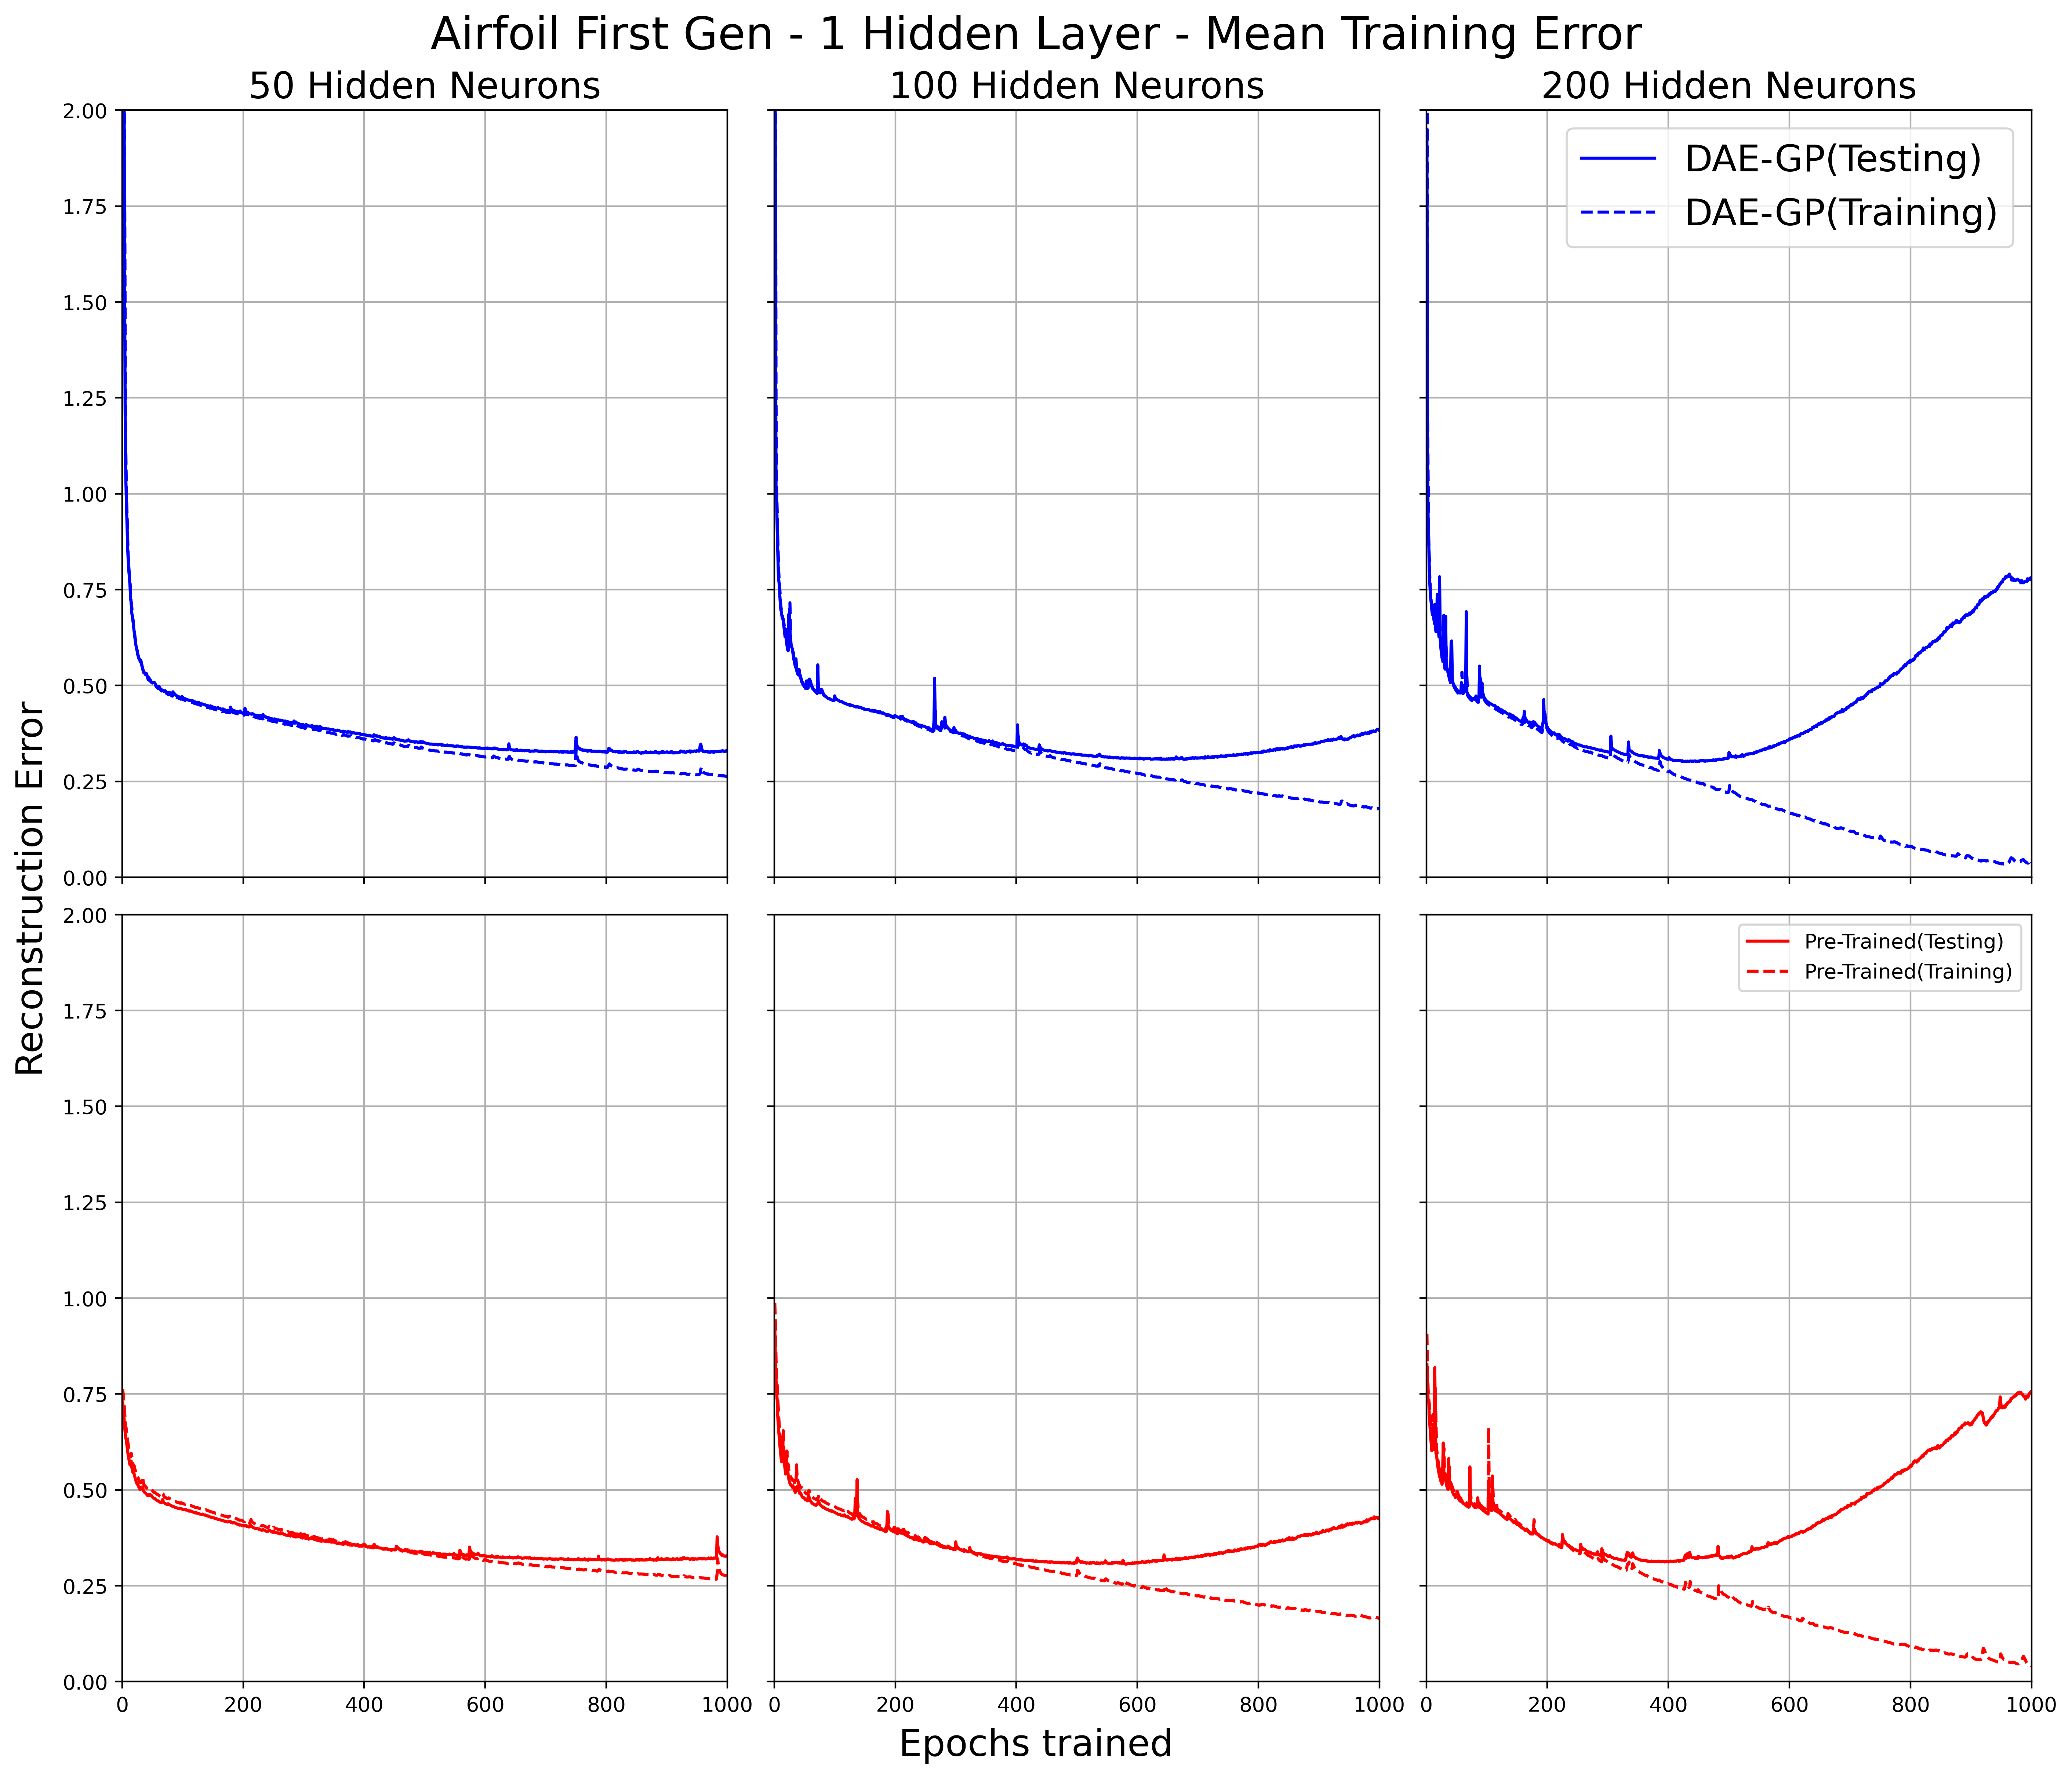

In [133]:
fig, ((lu, mu, ru), (ld, md, rd)) = plt.subplots(ncols=3,nrows=2, layout="constrained", sharex=True, sharey=True, dpi=DPI)
fig.set_size_inches(14,12)
epochs = np.arange(1,1001)


fig.suptitle(f"{BASE_TITLE} - Mean Training Error", fontsize=BIG)


fig.supxlabel("Epochs trained", fontsize=MID)
fig.supylabel("Reconstruction Error", fontsize=MID)

# l
reg_train_1 = np.array([reg_errors_1[x]["training"] for x in reg_test_nums_1])
reg_test_1 = np.array([reg_errors_1[x]["testing"] for x in reg_test_nums_1])
pt_train_1 = np.array([pt_errors_1[x]["training"] for x in pt_test_nums_1])
pt_test_1 = np.array([pt_errors_1[x]["testing"] for x in pt_test_nums_1])

reg_train_means_1 = reg_train_1.mean(axis=0)
reg_test_means_1 = reg_test_1.mean(axis=0)
pt_train_means_1 = pt_train_1.mean(axis=0)
pt_test_means_1 = pt_test_1.mean(axis=0)

lu.plot(epochs, reg_test_means_1,color=C_REG , label="DAE-GP(Testing)")
lu.plot(epochs, reg_train_means_1,color=C_REG, linestyle=TRAIN_LINESTYLE, label="DAE-GP(Training)")
ld.plot(epochs, pt_test_means_1, color=C_PT, label="Pre-Trained(Testing)")
ld.plot(epochs, pt_train_means_1, color=C_PT, linestyle=TRAIN_LINESTYLE, label="Pre-Trained(Training)")

lu.set_ylim(bottom=0, top=2)
lu.set_xlim(left=0, right=1000)
lu.set_title("50 Hidden Neurons",fontsize=MID)
lu.grid()
ld.grid()

# m
reg_train_2 = np.array([reg_errors_2[x]["training"] for x in reg_test_nums_2])
reg_test_2 = np.array([reg_errors_2[x]["testing"] for x in reg_test_nums_2])
pt_train_2 = np.array([pt_errors_2[x]["training"] for x in pt_test_nums_2])
pt_test_2 = np.array([pt_errors_2[x]["testing"] for x in pt_test_nums_2])

reg_train_means_2 = reg_train_2.mean(axis=0)
reg_test_means_2 = reg_test_2.mean(axis=0)
pt_train_means_2 = pt_train_2.mean(axis=0)
pt_test_means_2 = pt_test_2.mean(axis=0)

mu.plot(epochs, reg_test_means_2,color=C_REG , label="DAE-GP(Testing)")
mu.plot(epochs, reg_train_means_2,color=C_REG, linestyle=TRAIN_LINESTYLE, label="DAE-GP(Training)")
md.plot(epochs, pt_test_means_2, color=C_PT, label="Pre-Trained(Testing)")
md.plot(epochs, pt_train_means_2, color=C_PT, linestyle=TRAIN_LINESTYLE, label="Pre-Trained(Training)")

mu.set_title("100 Hidden Neurons",fontsize=MID)
mu.grid()
md.grid()

# r
reg_train_3 = np.array([reg_errors_3[x]["training"] for x in reg_test_nums_3])
reg_test_3 = np.array([reg_errors_3[x]["testing"] for x in reg_test_nums_3])
pt_train_3 = np.array([pt_errors_3[x]["training"] for x in pt_test_nums_3])
pt_test_3 = np.array([pt_errors_3[x]["testing"] for x in pt_test_nums_3])

reg_train_means_3 = reg_train_3.mean(axis=0)
reg_test_means_3 = reg_test_3.mean(axis=0)
pt_train_means_3 = pt_train_3.mean(axis=0)
pt_test_means_3 = pt_test_3.mean(axis=0)

ru.plot(epochs, reg_test_means_3,color=C_REG , label="DAE-GP(Testing)")
ru.plot(epochs, reg_train_means_3,color=C_REG, linestyle=TRAIN_LINESTYLE, label="DAE-GP(Training)")
rd.plot(epochs, pt_test_means_3, color=C_PT, label="Pre-Trained(Testing)")
rd.plot(epochs, pt_train_means_3, color=C_PT, linestyle=TRAIN_LINESTYLE, label="Pre-Trained(Training)")


ru.set_title("200 Hidden Neurons",fontsize=MID)
ru.grid()
ru.legend(fontsize=MID)
rd.grid()
rd.legend()

fig.savefig(f"{IMG_PATH}/airfoil_firstGen_mean_training_error_by_neurons_6plots.png")

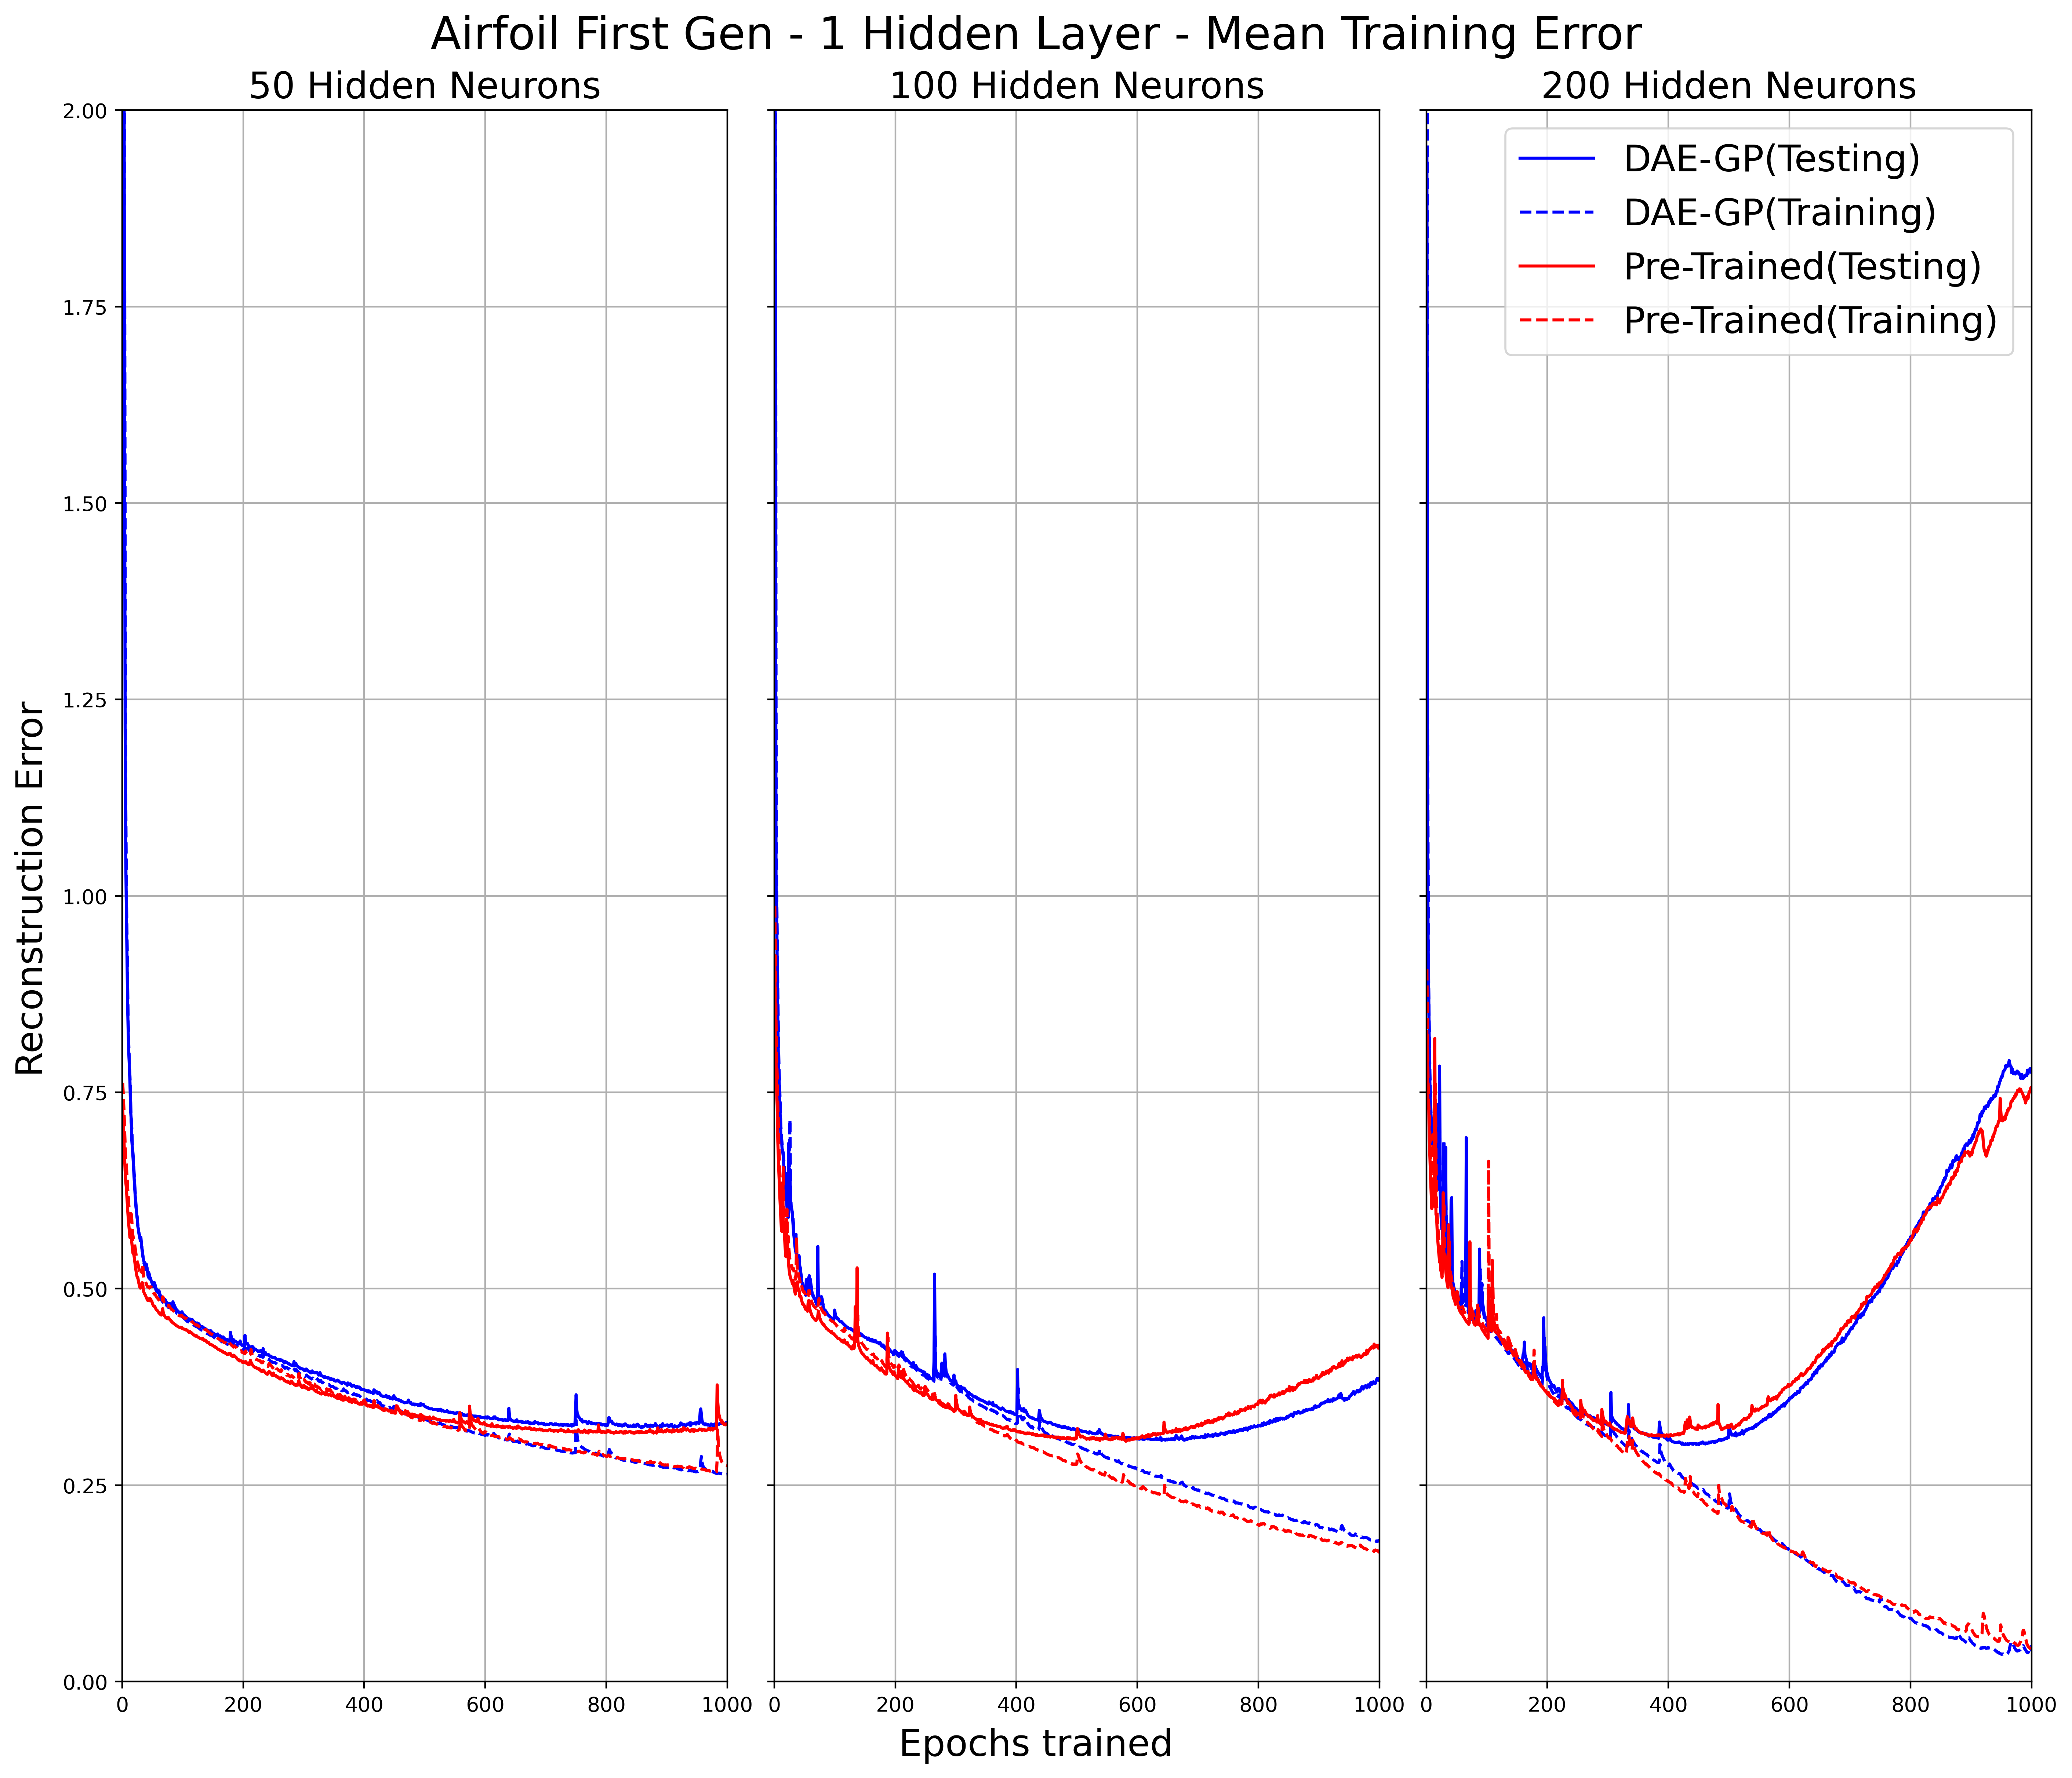

In [134]:
fig, (l,m, r) = plt.subplots(ncols=3, layout="constrained", sharex=True, sharey=True, dpi=DPI)
fig.set_size_inches(14,12)
epochs = np.arange(1,1001)


fig.suptitle(f"{BASE_TITLE} - Mean Training Error", fontsize=BIG)


fig.supxlabel("Epochs trained", fontsize=MID)
fig.supylabel("Reconstruction Error", fontsize=MID)

# l
reg_train_1 = np.array([reg_errors_1[x]["training"] for x in reg_test_nums_1])
reg_test_1 = np.array([reg_errors_1[x]["testing"] for x in reg_test_nums_1])
pt_train_1 = np.array([pt_errors_1[x]["training"] for x in pt_test_nums_1])
pt_test_1 = np.array([pt_errors_1[x]["testing"] for x in pt_test_nums_1])

reg_train_means_1 = reg_train_1.mean(axis=0)
reg_test_means_1 = reg_test_1.mean(axis=0)
pt_train_means_1 = pt_train_1.mean(axis=0)
pt_test_means_1 = pt_test_1.mean(axis=0)

l.plot(epochs, reg_test_means_1,color=C_REG , label="DAE-GP(Testing)")
l.plot(epochs, reg_train_means_1,color=C_REG, linestyle=TRAIN_LINESTYLE, label="DAE-GP(Training)")
l.plot(epochs, pt_test_means_1, color=C_PT, label="Pre-Trained(Testing)")
l.plot(epochs, pt_train_means_1, color=C_PT, linestyle=TRAIN_LINESTYLE, label="Pre-Trained(Training)")

l.set_ylim(bottom=0, top=2)
l.set_xlim(left=0, right=1000)
l.set_title("50 Hidden Neurons",fontsize=MID)
l.grid()

# m
reg_train_2 = np.array([reg_errors_2[x]["training"] for x in reg_test_nums_2])
reg_test_2 = np.array([reg_errors_2[x]["testing"] for x in reg_test_nums_2])
pt_train_2 = np.array([pt_errors_2[x]["training"] for x in pt_test_nums_2])
pt_test_2 = np.array([pt_errors_2[x]["testing"] for x in pt_test_nums_2])

reg_train_means_2 = reg_train_2.mean(axis=0)
reg_test_means_2 = reg_test_2.mean(axis=0)
pt_train_means_2 = pt_train_2.mean(axis=0)
pt_test_means_2 = pt_test_2.mean(axis=0)

m.plot(epochs, reg_test_means_2,color=C_REG , label="DAE-GP(Testing)")
m.plot(epochs, reg_train_means_2,color=C_REG, linestyle=TRAIN_LINESTYLE, label="DAE-GP(Training)")
m.plot(epochs, pt_test_means_2, color=C_PT, label="Pre-Trained(Testing)")
m.plot(epochs, pt_train_means_2, color=C_PT, linestyle=TRAIN_LINESTYLE, label="Pre-Trained(Training)")

m.set_title("100 Hidden Neurons",fontsize=MID)
m.grid()

# r
reg_train_3 = np.array([reg_errors_3[x]["training"] for x in reg_test_nums_3])
reg_test_3 = np.array([reg_errors_3[x]["testing"] for x in reg_test_nums_3])
pt_train_3 = np.array([pt_errors_3[x]["training"] for x in pt_test_nums_3])
pt_test_3 = np.array([pt_errors_3[x]["testing"] for x in pt_test_nums_3])

reg_train_means_3 = reg_train_3.mean(axis=0)
reg_test_means_3 = reg_test_3.mean(axis=0)
pt_train_means_3 = pt_train_3.mean(axis=0)
pt_test_means_3 = pt_test_3.mean(axis=0)

r.plot(epochs, reg_test_means_3,color=C_REG , label="DAE-GP(Testing)")
r.plot(epochs, reg_train_means_3,color=C_REG, linestyle=TRAIN_LINESTYLE, label="DAE-GP(Training)")
r.plot(epochs, pt_test_means_3, color=C_PT, label="Pre-Trained(Testing)")
r.plot(epochs, pt_train_means_3, color=C_PT, linestyle=TRAIN_LINESTYLE, label="Pre-Trained(Training)")


r.set_title("200 Hidden Neurons",fontsize=MID)
r.grid()
r.legend(fontsize=MID)


fig.savefig(f"{IMG_PATH}/airfoil_firstGen_mean_training_error_by_neurons_3plots.png")

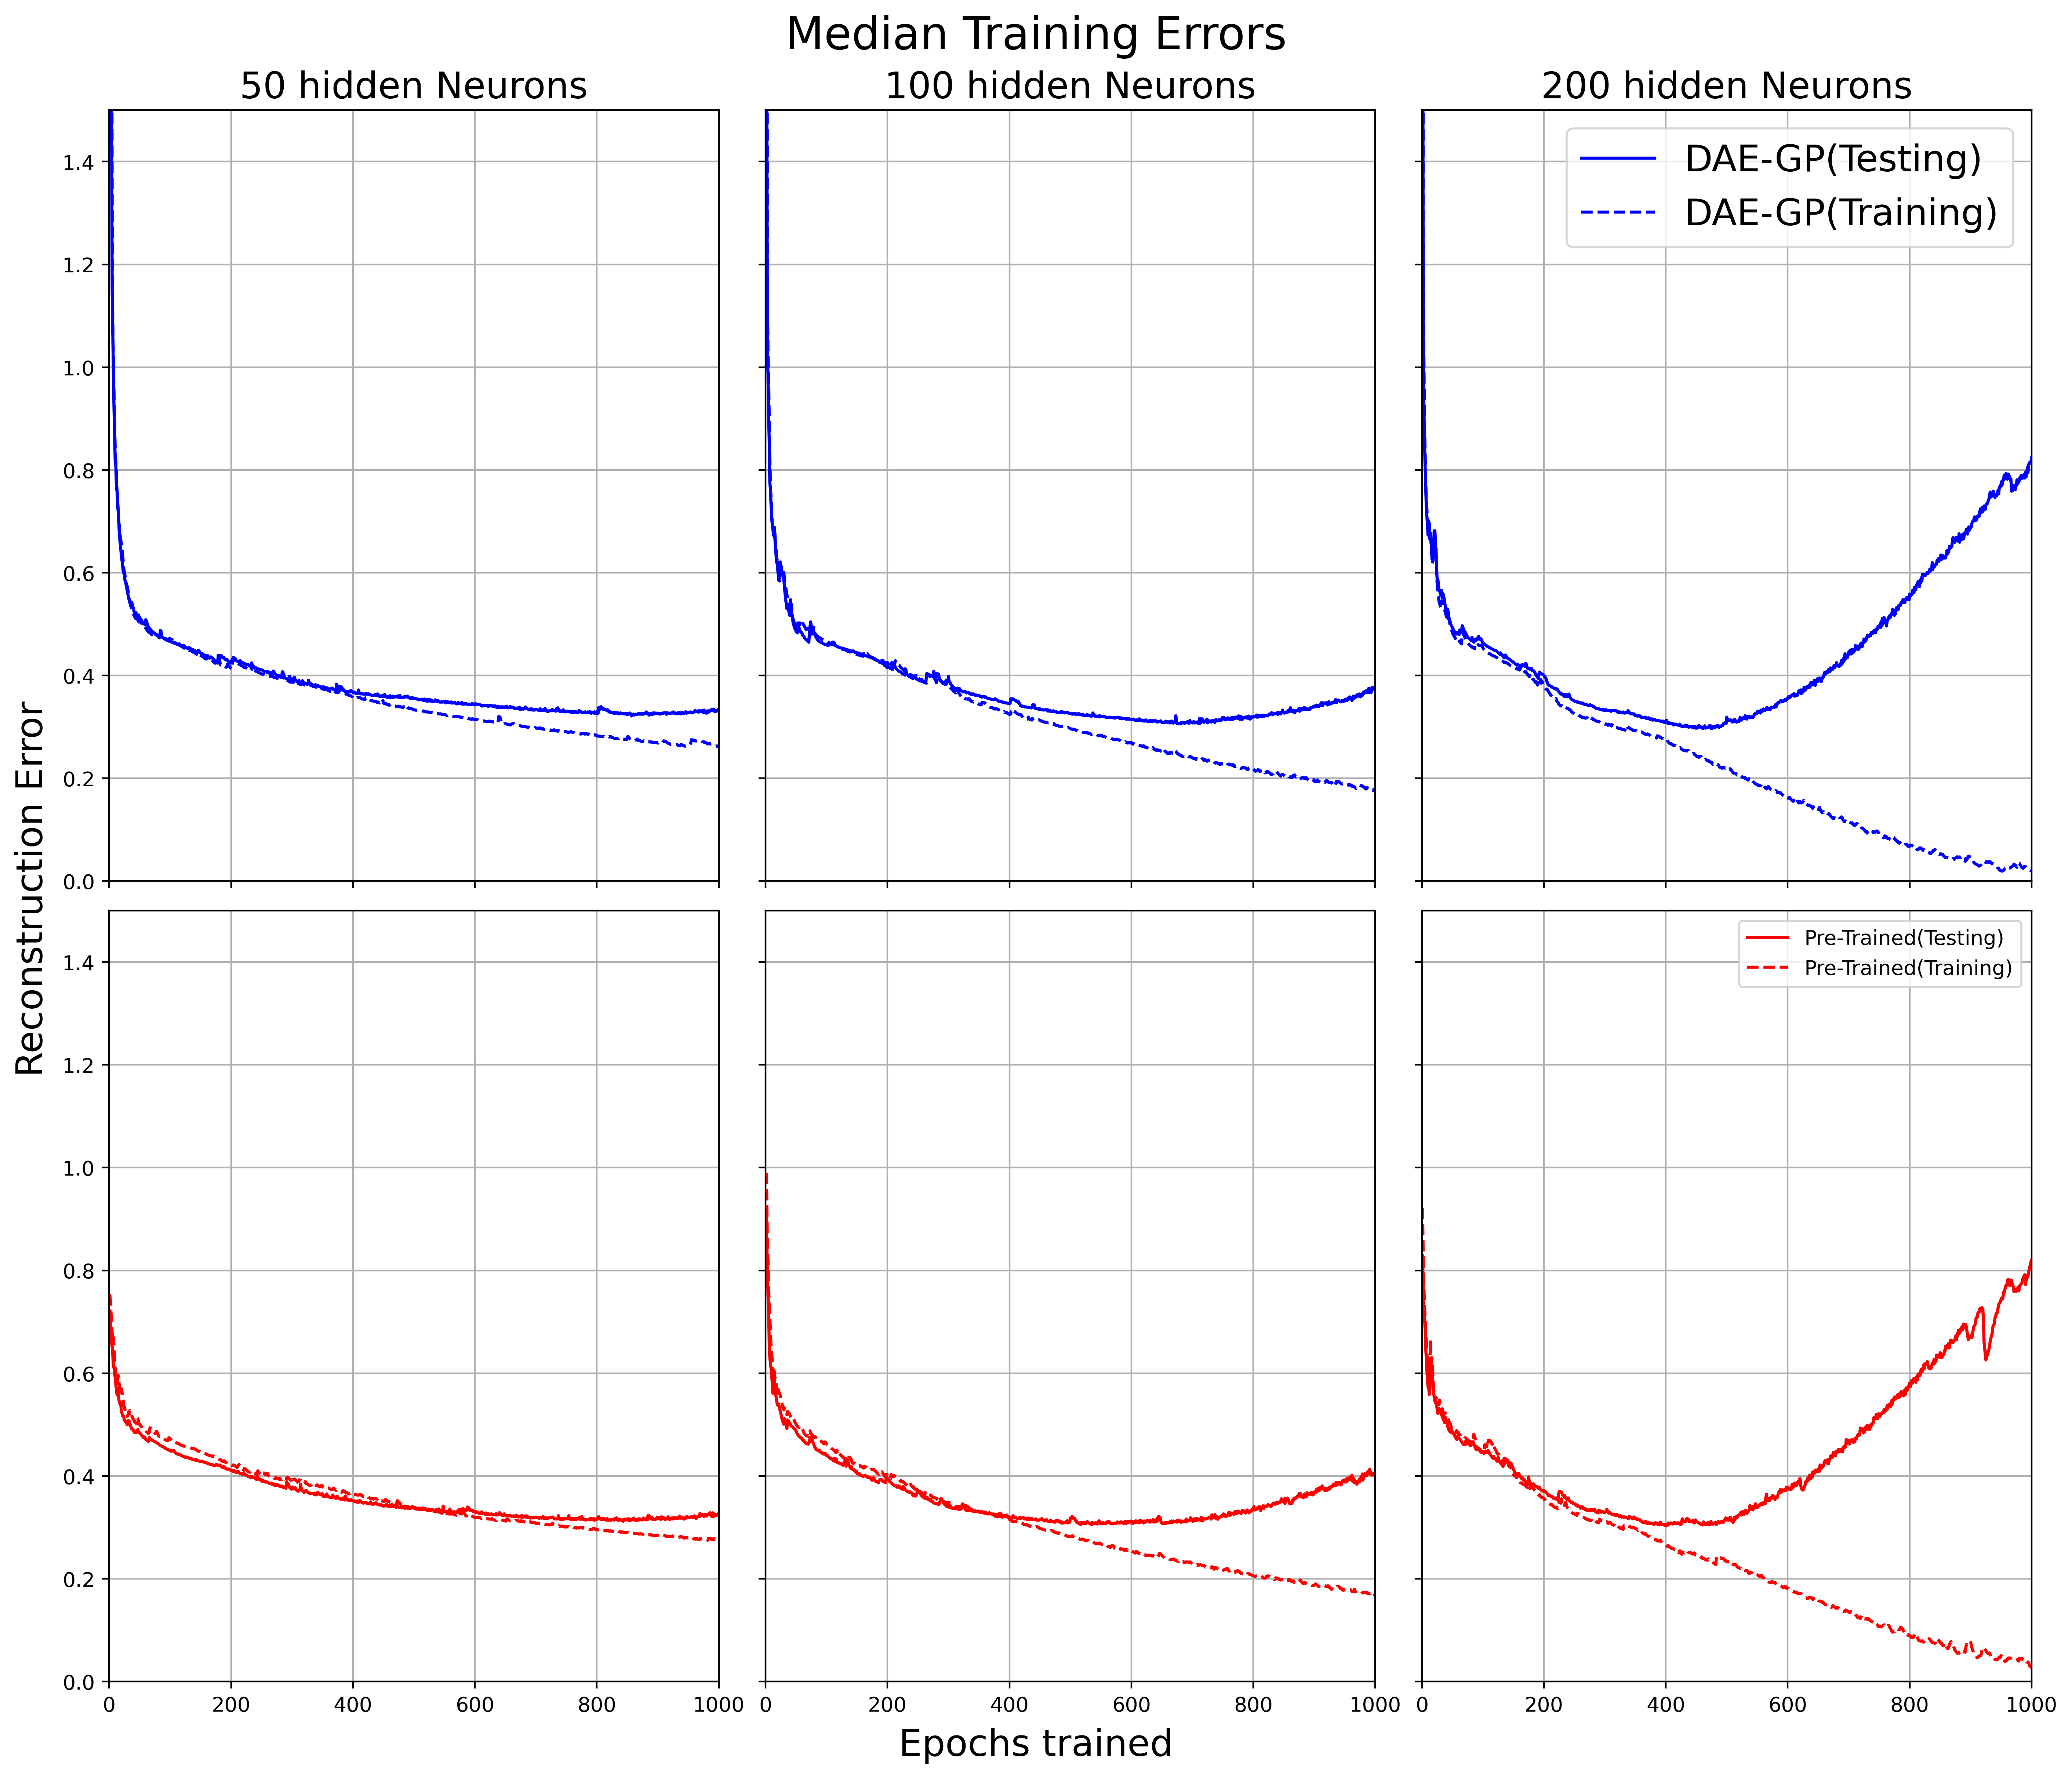

In [135]:
fig, ((lu, mu, ru), (ld, md, rd)) = plt.subplots(ncols=3,nrows=2, layout="constrained", sharex=True, sharey=True, dpi=DPI)
fig.set_size_inches(14,12)
epochs = np.arange(1,1001)

#fig.suptitle("Airfoil first Generation", fontsize=BIG)
fig.suptitle(f"Median Training Errors", fontsize=BIG)
fig.supxlabel("Epochs trained", fontsize=MID)
fig.supylabel("Reconstruction Error", fontsize=MID)

# l
reg_train_1 = np.array([reg_errors_1[x]["training"] for x in reg_test_nums_1])
reg_test_1 = np.array([reg_errors_1[x]["testing"] for x in reg_test_nums_1])
pt_train_1 = np.array([pt_errors_1[x]["training"] for x in pt_test_nums_1])
pt_test_1 = np.array([pt_errors_1[x]["testing"] for x in pt_test_nums_1])

reg_train_median_1 = np.median(reg_train_1, axis=0)
reg_test_median_1 = np.median(reg_test_1, axis=0)
pt_train_median_1 = np.median(pt_train_1, axis=0)
pt_test_median_1 = np.median(pt_test_1, axis=0)

lu.plot(epochs, reg_test_median_1,color=C_REG , label="DAE-GP(Testing)")
lu.plot(epochs, reg_train_median_1,color=C_REG, linestyle=TRAIN_LINESTYLE, label="DAE-GP(Training)")
ld.plot(epochs, pt_test_median_1, color=C_PT, label="Pre-Trained(Testing)")
ld.plot(epochs, pt_train_median_1, color=C_PT, linestyle=TRAIN_LINESTYLE, label="Pre-Trained(Training)")

lu.set_ylim(bottom=0, top=1.5)
lu.set_xlim(left=0, right=1000)


lu.set_title("50 hidden Neurons",fontsize=MID)
lu.grid()
ld.grid()

# m
reg_train_2 = np.array([reg_errors_2[x]["training"] for x in reg_test_nums_2])
reg_test_2 = np.array([reg_errors_2[x]["testing"] for x in reg_test_nums_2])
pt_train_2 = np.array([pt_errors_2[x]["training"] for x in pt_test_nums_2])
pt_test_2 = np.array([pt_errors_2[x]["testing"] for x in pt_test_nums_2])

reg_train_median_2 = np.median(reg_train_2, axis=0)
reg_test_median_2 = np.median(reg_test_2, axis=0)
pt_train_median_2 = np.median(pt_train_2, axis=0)
pt_test_median_2 = np.median(pt_test_2, axis=0)


mu.plot(epochs, reg_test_median_2,color=C_REG , label="DAE-GP(Testing)")
mu.plot(epochs, reg_train_median_2,color=C_REG, linestyle=TRAIN_LINESTYLE, label="DAE-GP(Training)")
md.plot(epochs, pt_test_median_2, color=C_PT, label="Pre-Trained(Testing)")
md.plot(epochs, pt_train_median_2, color=C_PT, linestyle=TRAIN_LINESTYLE, label="Pre-Trained(Training)")

mu.set_title("100 hidden Neurons",fontsize=MID)
mu.grid()
md.grid()

# r
reg_train_3 = np.array([reg_errors_3[x]["training"] for x in reg_test_nums_3])
reg_test_3 = np.array([reg_errors_3[x]["testing"] for x in reg_test_nums_3])
pt_train_3 = np.array([pt_errors_3[x]["training"] for x in pt_test_nums_3])
pt_test_3 = np.array([pt_errors_3[x]["testing"] for x in pt_test_nums_3])

reg_train_median_3 = np.median(reg_train_3, axis=0)
reg_test_median_3 = np.median(reg_test_3, axis=0)
pt_train_median_3 = np.median(pt_train_3, axis=0)
pt_test_median_3 = np.median(pt_test_3, axis=0)

ru.plot(epochs, reg_test_median_3,color=C_REG , label="DAE-GP(Testing)")
ru.plot(epochs, reg_train_median_3,color=C_REG, linestyle=TRAIN_LINESTYLE, label="DAE-GP(Training)")
rd.plot(epochs, pt_test_median_3, color=C_PT, label="Pre-Trained(Testing)")
rd.plot(epochs, pt_train_median_3, color=C_PT, linestyle=TRAIN_LINESTYLE, label="Pre-Trained(Training)")

ru.set_title("200 hidden Neurons",fontsize=MID)
ru.grid()
ru.legend(fontsize=MID)
rd.legend()
rd.grid()

fig.savefig(f"{IMG_PATH}/airfoil_firstGen_median_training_error_by_neurons_6plots.png")

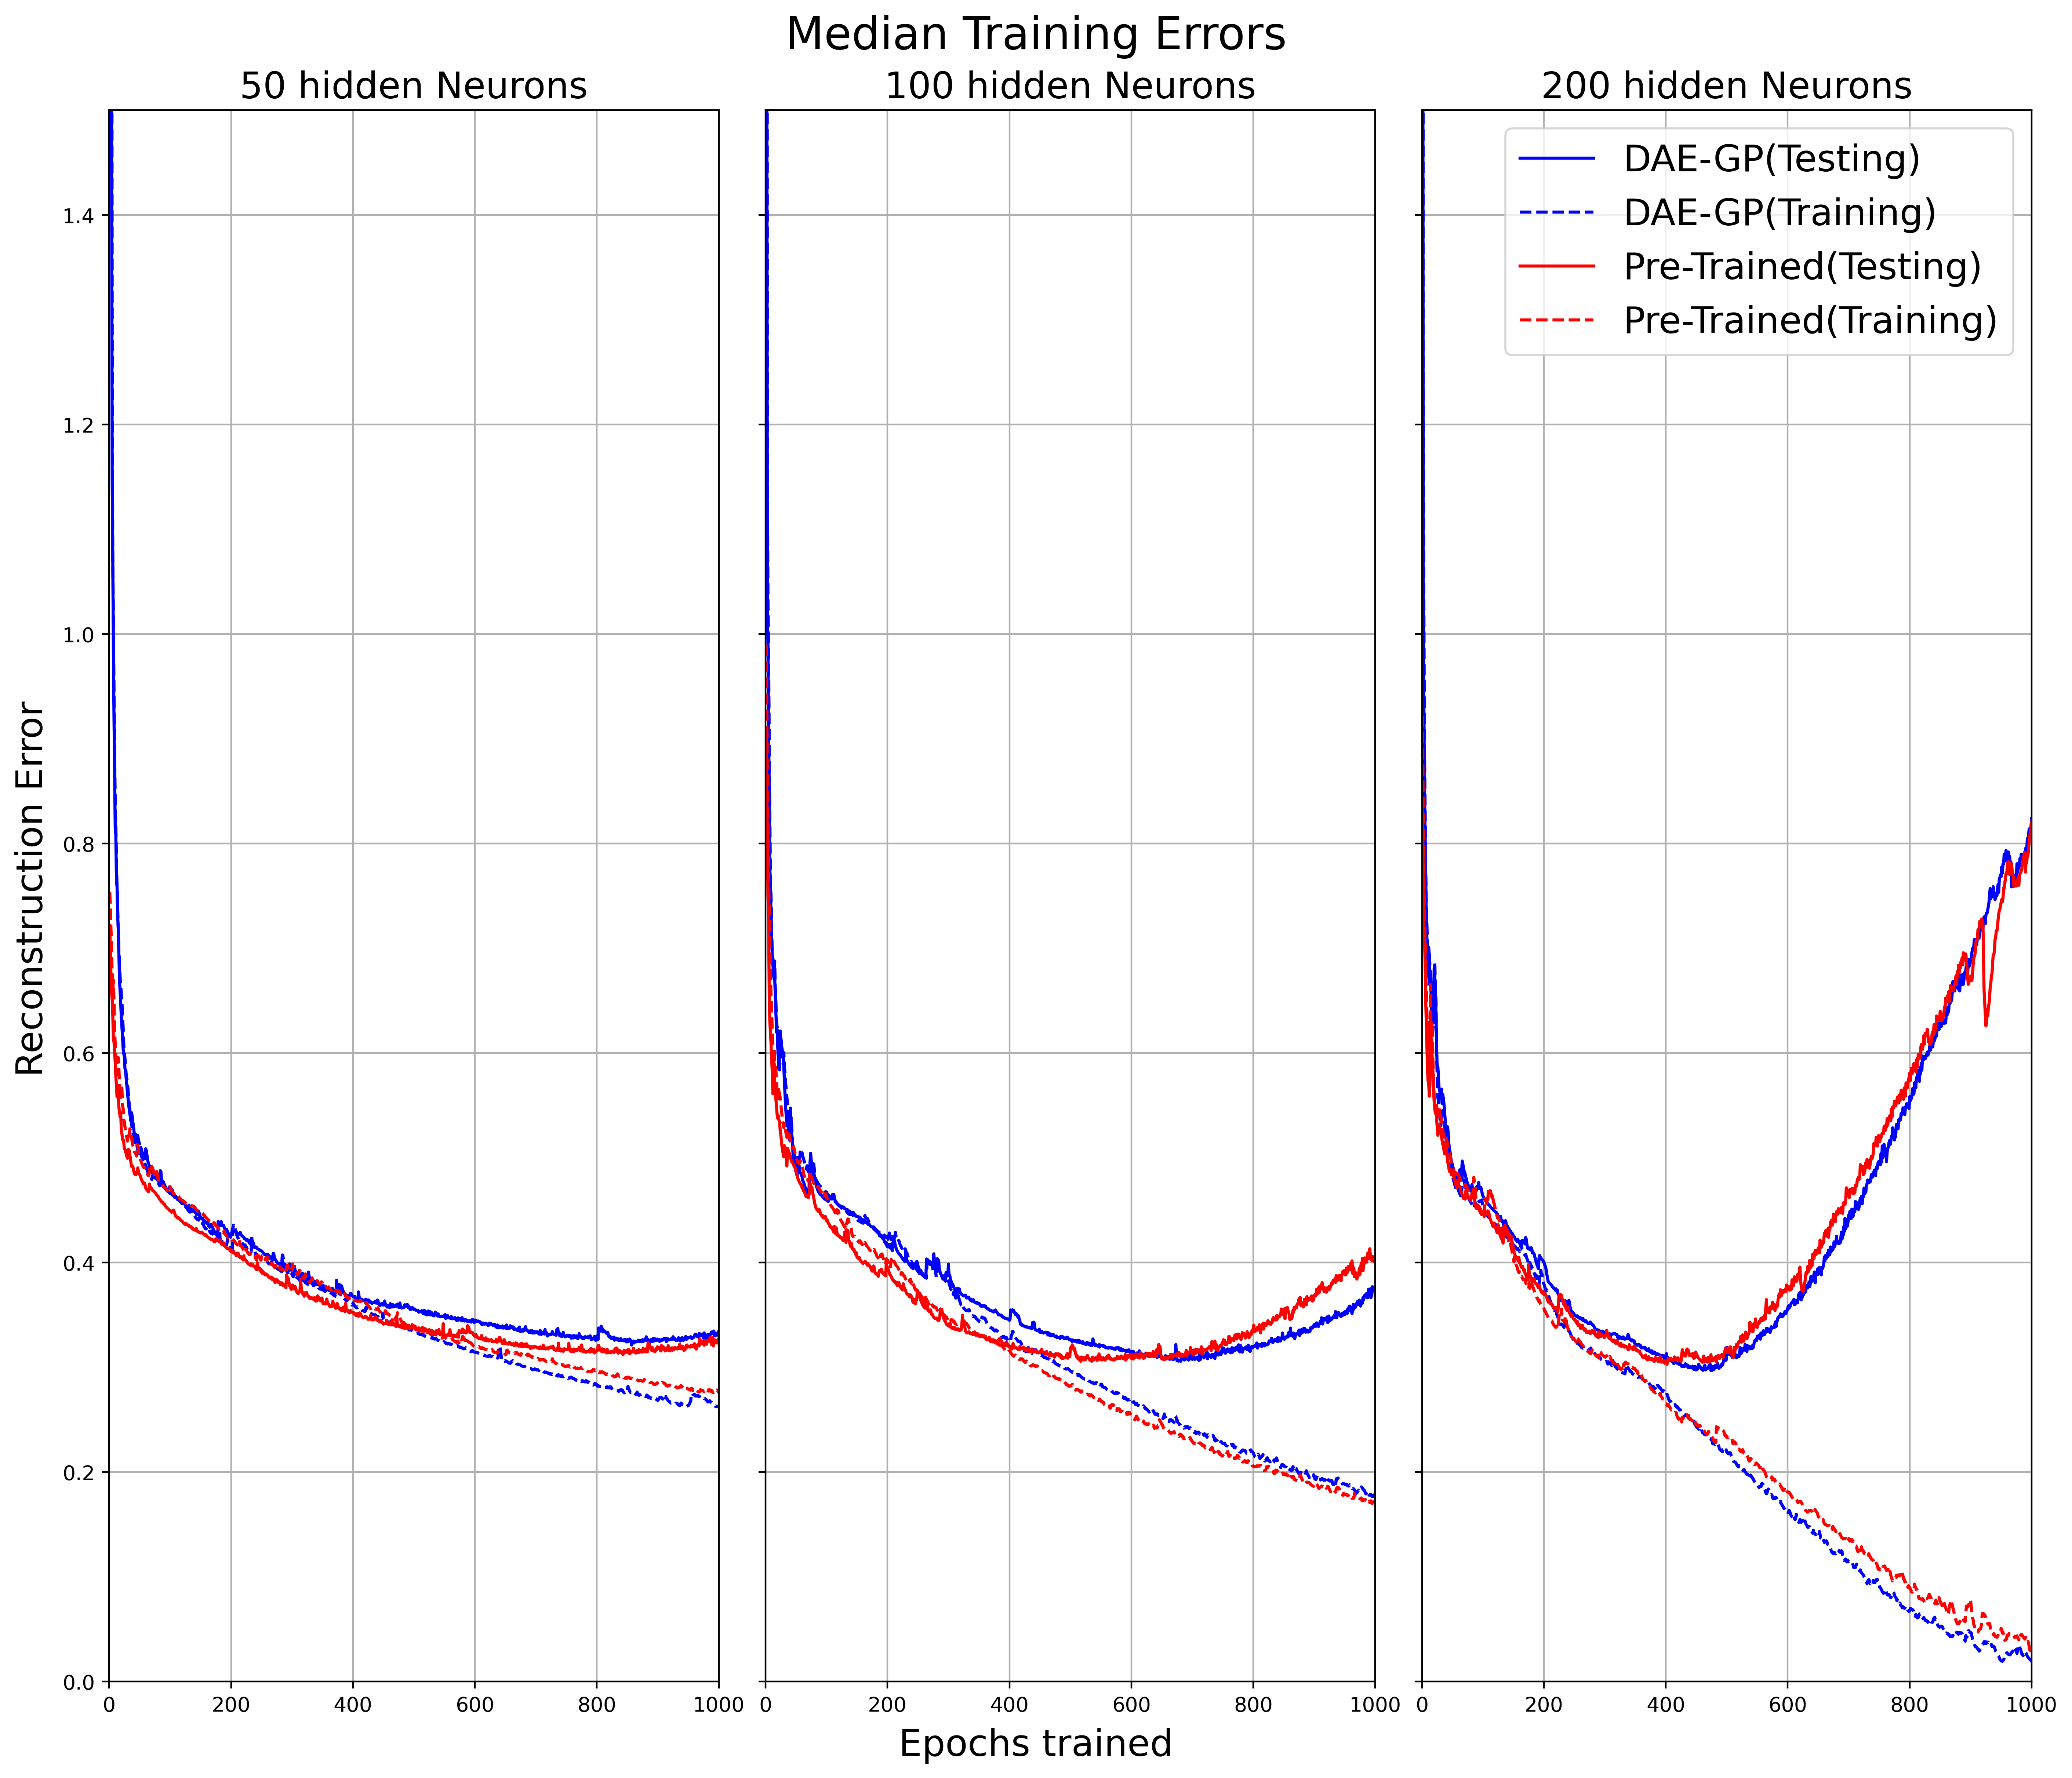

In [136]:
fig, (l,m, r) = plt.subplots(ncols=3, layout="constrained", sharex=True, sharey=True, dpi=DPI)
fig.set_size_inches(14,12)
epochs = np.arange(1,1001)

#fig.suptitle("Airfoil first Generation", fontsize=BIG)
fig.suptitle(f"Median Training Errors", fontsize=BIG)
fig.supxlabel("Epochs trained", fontsize=MID)
fig.supylabel("Reconstruction Error", fontsize=MID)

# l
reg_train_1 = np.array([reg_errors_1[x]["training"] for x in reg_test_nums_1])
reg_test_1 = np.array([reg_errors_1[x]["testing"] for x in reg_test_nums_1])
pt_train_1 = np.array([pt_errors_1[x]["training"] for x in pt_test_nums_1])
pt_test_1 = np.array([pt_errors_1[x]["testing"] for x in pt_test_nums_1])

reg_train_median_1 = np.median(reg_train_1, axis=0)
reg_test_median_1 = np.median(reg_test_1, axis=0)
pt_train_median_1 = np.median(pt_train_1, axis=0)
pt_test_median_1 = np.median(pt_test_1, axis=0)

l.plot(epochs, reg_test_median_1,color=C_REG , label="DAE-GP(Testing)")
l.plot(epochs, reg_train_median_1,color=C_REG, linestyle=TRAIN_LINESTYLE, label="DAE-GP(Training)")
l.plot(epochs, pt_test_median_1, color=C_PT, label="Pre-Trained(Testing)")
l.plot(epochs, pt_train_median_1, color=C_PT, linestyle=TRAIN_LINESTYLE, label="Pre-Trained(Training)")

l.set_ylim(bottom=0, top=1.5)
l.set_xlim(left=0, right=1000)


l.set_title("50 hidden Neurons",fontsize=MID)
l.grid()

# m
reg_train_2 = np.array([reg_errors_2[x]["training"] for x in reg_test_nums_2])
reg_test_2 = np.array([reg_errors_2[x]["testing"] for x in reg_test_nums_2])
pt_train_2 = np.array([pt_errors_2[x]["training"] for x in pt_test_nums_2])
pt_test_2 = np.array([pt_errors_2[x]["testing"] for x in pt_test_nums_2])

reg_train_median_2 = np.median(reg_train_2, axis=0)
reg_test_median_2 = np.median(reg_test_2, axis=0)
pt_train_median_2 = np.median(pt_train_2, axis=0)
pt_test_median_2 = np.median(pt_test_2, axis=0)


m.plot(epochs, reg_test_median_2,color=C_REG , label="DAE-GP(Testing)")
m.plot(epochs, reg_train_median_2,color=C_REG, linestyle=TRAIN_LINESTYLE, label="DAE-GP(Training)")
m.plot(epochs, pt_test_median_2, color=C_PT, label="Pre-Trained(Testing)")
m.plot(epochs, pt_train_median_2, color=C_PT, linestyle=TRAIN_LINESTYLE, label="Pre-Trained(Training)")

m.set_title("100 hidden Neurons",fontsize=MID)
m.grid()

# r
reg_train_3 = np.array([reg_errors_3[x]["training"] for x in reg_test_nums_3])
reg_test_3 = np.array([reg_errors_3[x]["testing"] for x in reg_test_nums_3])
pt_train_3 = np.array([pt_errors_3[x]["training"] for x in pt_test_nums_3])
pt_test_3 = np.array([pt_errors_3[x]["testing"] for x in pt_test_nums_3])

reg_train_median_3 = np.median(reg_train_3, axis=0)
reg_test_median_3 = np.median(reg_test_3, axis=0)
pt_train_median_3 = np.median(pt_train_3, axis=0)
pt_test_median_3 = np.median(pt_test_3, axis=0)

r.plot(epochs, reg_test_median_3,color=C_REG , label="DAE-GP(Testing)")
r.plot(epochs, reg_train_median_3,color=C_REG, linestyle=TRAIN_LINESTYLE, label="DAE-GP(Training)")
r.plot(epochs, pt_test_median_3, color=C_PT, label="Pre-Trained(Testing)")
r.plot(epochs, pt_train_median_3, color=C_PT, linestyle=TRAIN_LINESTYLE, label="Pre-Trained(Training)")

r.set_title("200 hidden Neurons",fontsize=MID)
r.grid()
r.legend(fontsize=MID)


fig.savefig(f"{IMG_PATH}/airfoil_firstGen_median_training_error_by_neurons_3plots.png")

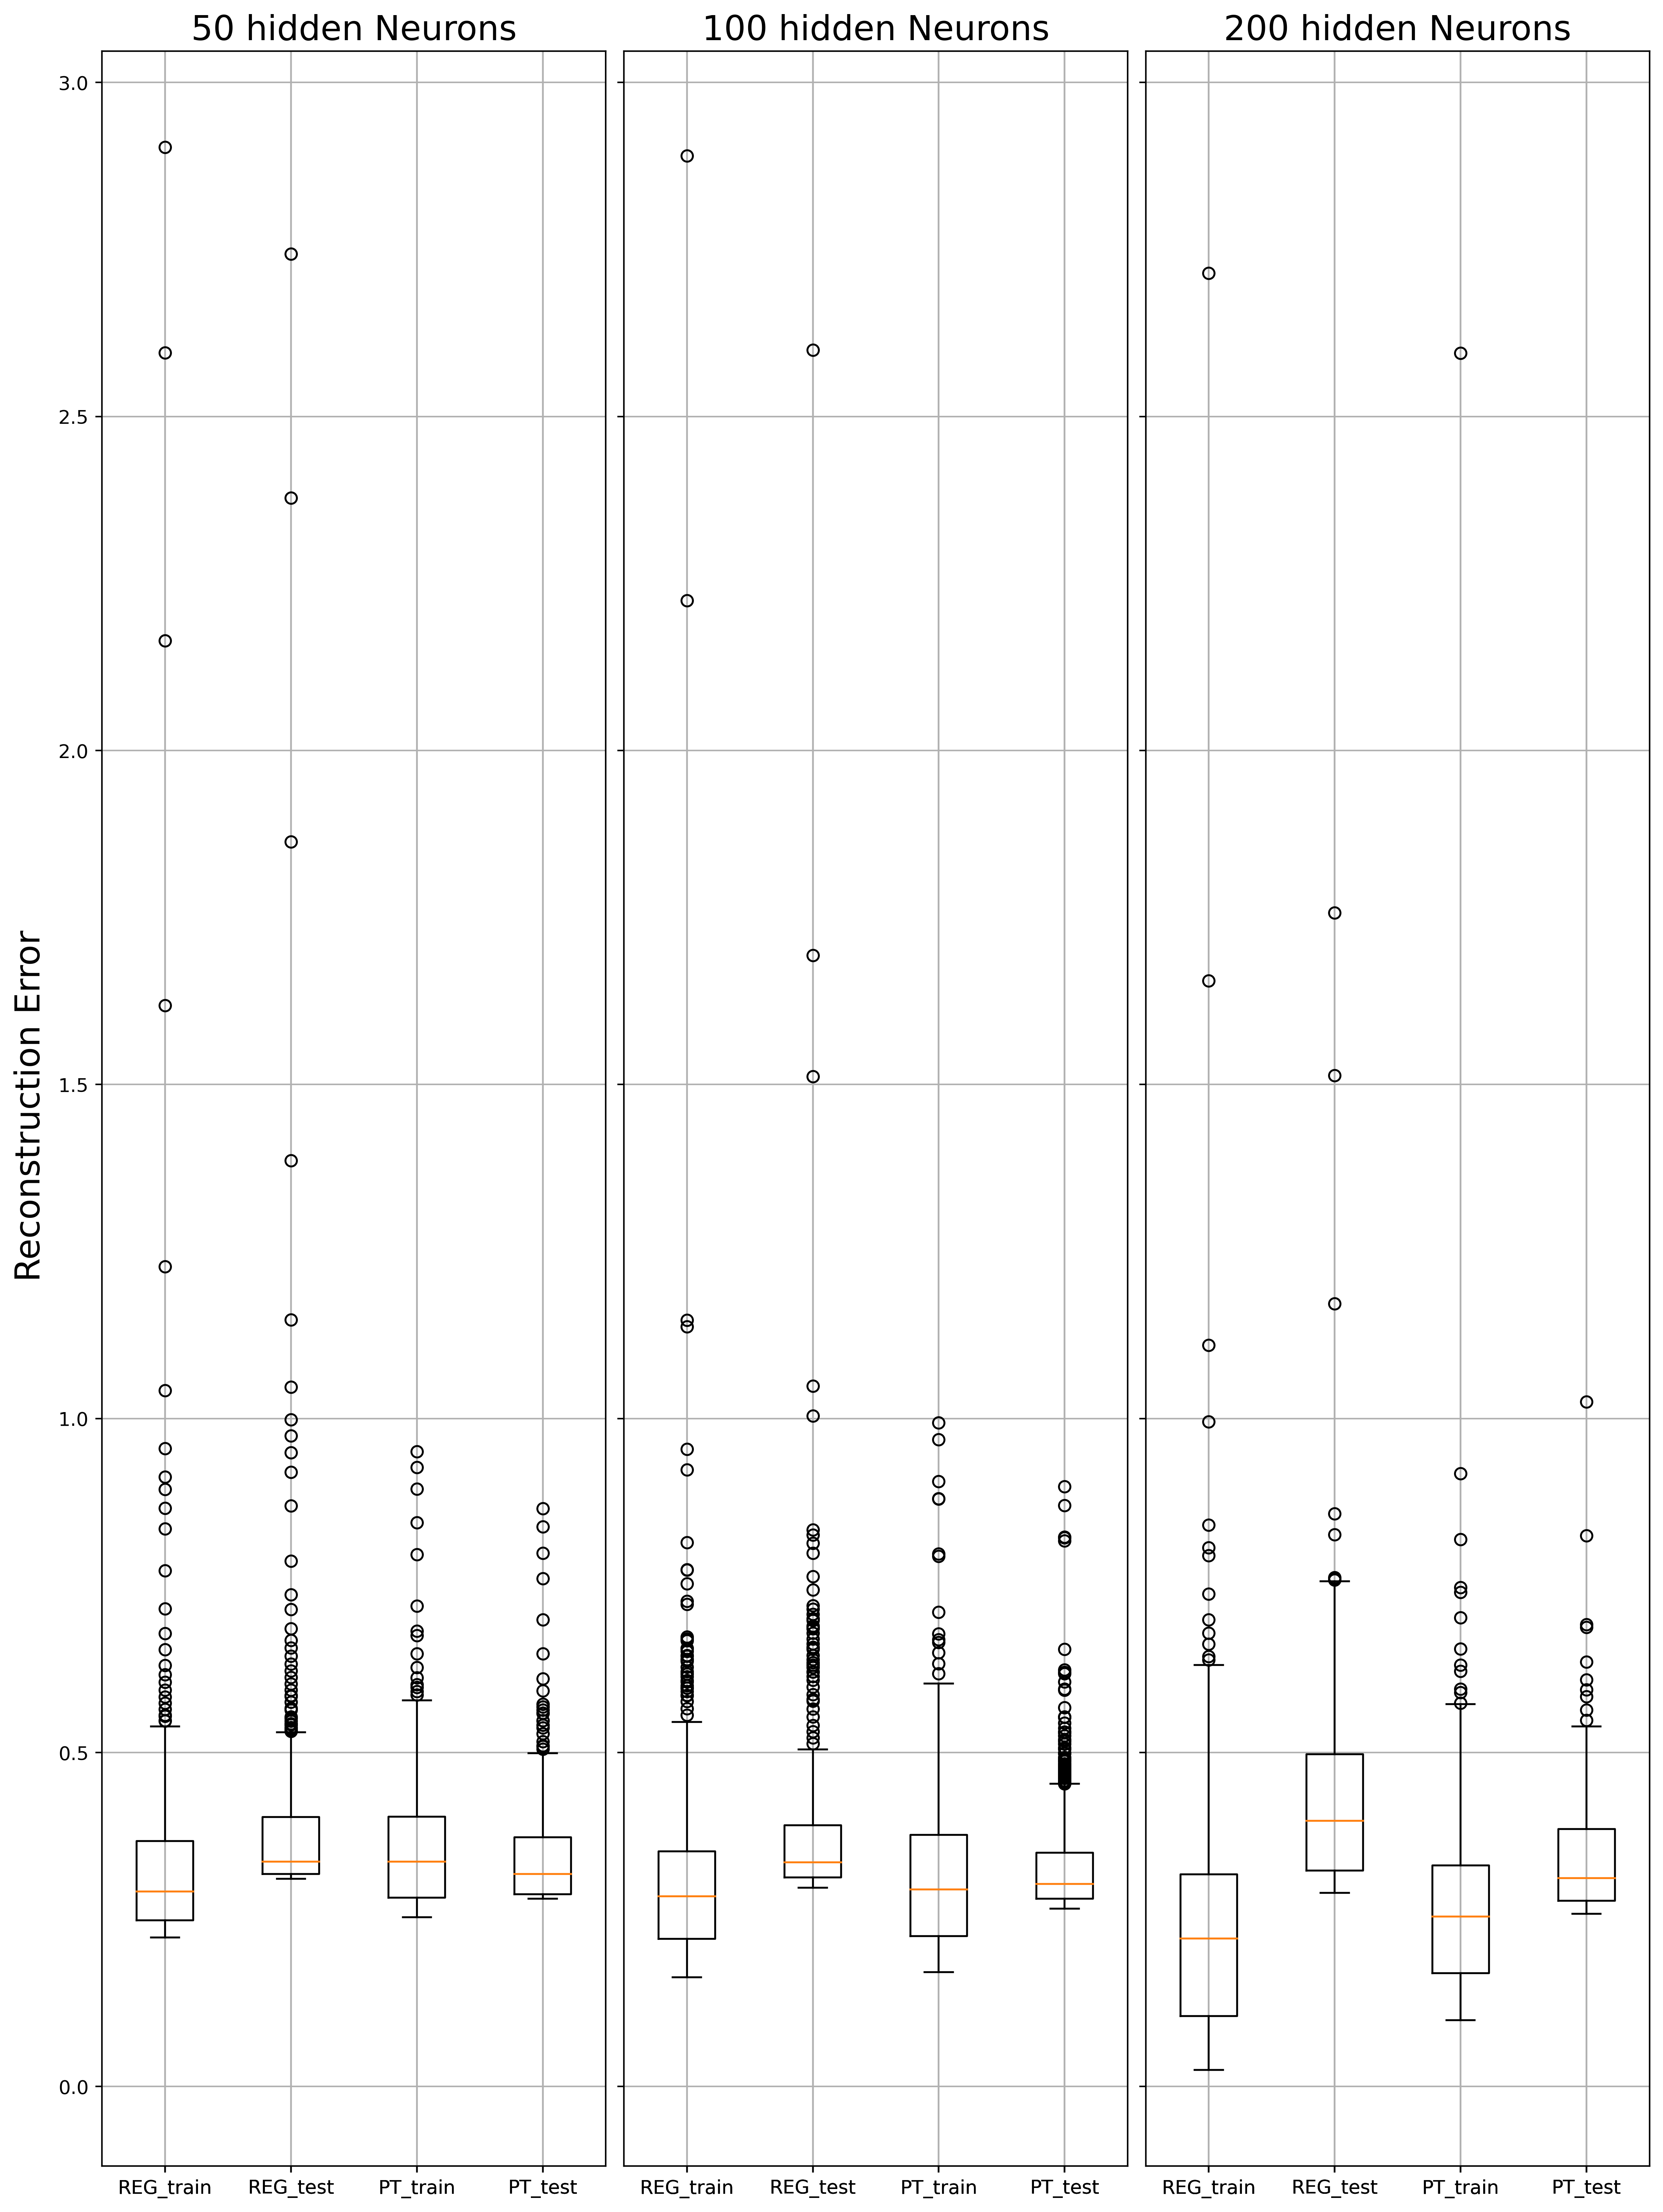

In [137]:
fig, (l,m,r) = plt.subplots(ncols=3, layout="constrained", sharex=True, sharey=True, dpi=DPI)
fig.set_size_inches(12,16)


LABELS = ["REG_train", "REG_test", "PT_train", "PT_test"]
#LABELS=["DAE-GP(Training)", "DAE-GP(Testing)", "Pre-Trained(Training)", "Pre-Trained(Testing)"]


"""
ax.boxplot(
        x = [sample_a, sample_b, sample_c, sample_d],
        labels=[a_label, b_label, c_label, d_label]
    )
"""


#fig.suptitle("Airfoil first Generation", fontsize=BIG)
fig.supylabel("Reconstruction Error", fontsize=MID)

# l
reg_train_1 = np.array([reg_errors_1[x]["training"] for x in reg_test_nums_1])
reg_test_1 = np.array([reg_errors_1[x]["testing"] for x in reg_test_nums_1])
pt_train_1 = np.array([pt_errors_1[x]["training"] for x in pt_test_nums_1])
pt_test_1 = np.array([pt_errors_1[x]["testing"] for x in pt_test_nums_1])

l.set_title("50 hidden Neurons",fontsize=MID)

l.boxplot(
    x = [reg_train_1[-1], reg_test_1[-1], pt_train_1[-1], pt_test_1[-1]],
    labels=LABELS,
    #vert=False
)
l.grid()


# m
reg_train_2 = np.array([reg_errors_2[x]["training"] for x in reg_test_nums_2])
reg_test_2 = np.array([reg_errors_2[x]["testing"] for x in reg_test_nums_2])
pt_train_2 = np.array([pt_errors_2[x]["training"] for x in pt_test_nums_2])
pt_test_2 = np.array([pt_errors_2[x]["testing"] for x in pt_test_nums_2])


m.set_title("100 hidden Neurons",fontsize=MID)

m.boxplot(
    x = [reg_train_2[-1], reg_test_2[-1], pt_train_2[-1], pt_test_2[-1]],
    labels=LABELS,
    #vert=False
)
m.grid()

# r
reg_train_3 = np.array([reg_errors_3[x]["training"] for x in reg_test_nums_3])
reg_test_3 = np.array([reg_errors_3[x]["testing"] for x in reg_test_nums_3])
pt_train_3 = np.array([pt_errors_3[x]["training"] for x in pt_test_nums_3])
pt_test_3 = np.array([pt_errors_3[x]["testing"] for x in pt_test_nums_3])


r.set_title("200 hidden Neurons",fontsize=MID)

r.boxplot(
    x = [reg_train_3[-1], reg_test_3[-1], pt_train_3[-1], pt_test_3[-1]],
    labels=LABELS,
    #vert=False
)
r.grid()


fig.savefig(f"{IMG_PATH}/airfoil_firstGen_boxplot_training_error_by_neurons.png")

In [138]:
import datetime

def print_current_date_and_time():
  now = datetime.datetime.now()
  print(f'Notebook last executed at: {now.strftime("%Y-%m-%d %H:%M:%S")}')

print_current_date_and_time()

Notebook last executed at: 2023-01-11 17:28:17
